#### This notebook generates TD-AUC for linear models

Packages needed
- scikit-survival [sksurv]
- matplotlib
- numpy

In [1]:
from sksurv.metrics import cumulative_dynamic_auc
from sksurv.linear_model import CoxnetSurvivalAnalysis

import matplotlib
matplotlib.rcParams.update({'font.size': 10})

import numpy as np
from matplotlib import pyplot as plt

from utils import DataLoader, get_structured_array

Using TensorFlow backend.


#### Generate outputs from the different models

In [5]:
# fold is 0-indexed
# fold=3 and fold=4 were used to generate the results in the paper

data = DataLoader(fold=4, num_genes=500)
l1_ratio = 0.3
n_alphas = 100

y_train = get_structured_array(data.y_train_bool, data.y_train_value)
print('Training size', y_train.shape)
y_valid = get_structured_array(data.y_valid_bool, data.y_valid_value)
print('Validation set', y_valid.shape)
y_test = get_structured_array(data.y_test_bool, data.y_test_value)
print('Test set', y_test.shape)

##### Genomics

coxnet = CoxnetSurvivalAnalysis(l1_ratio=l1_ratio, n_alphas=n_alphas)
coxnet.fit(data.gen_train.cpu().detach().numpy(), 
           y_train)
gen_outputs = coxnet.predict(data.gen_test.cpu().detach().numpy())

##### Pyradiomics

coxnet = CoxnetSurvivalAnalysis(l1_ratio=l1_ratio, n_alphas=n_alphas)
coxnet.fit(data.pyrad_train.cpu().detach().numpy(), 
           y_train)
pyrad_outputs = coxnet.predict(data.pyrad_test.cpu().detach().numpy())

##### Densenet

coxnet = CoxnetSurvivalAnalysis(l1_ratio=l1_ratio, n_alphas=n_alphas)
coxnet.fit(data.dense_train.cpu().detach().numpy(), 
           y_train)
dense_outputs = coxnet.predict(data.dense_test.cpu().detach().numpy())

##### Genomics-PyRadiomics

coxnet = CoxnetSurvivalAnalysis(l1_ratio=l1_ratio, n_alphas=n_alphas)
feat_train = np.concatenate((data.gen_train.cpu().detach().numpy(), 
                             data.pyrad_train.cpu().detach().numpy()), axis=1)
coxnet.fit(feat_train, y_train)
feat_valid = np.concatenate((data.gen_valid.cpu().detach().numpy(), 
                             data.pyrad_valid.cpu().detach().numpy()), axis=1)
feat_test = np.concatenate((data.gen_test.cpu().detach().numpy(), 
                             data.pyrad_test.cpu().detach().numpy()), axis=1)
feat1_outputs = coxnet.predict(feat_test)

##### Genomics-DenseNet
coxnet = CoxnetSurvivalAnalysis(l1_ratio=l1_ratio, n_alphas=n_alphas)
feat_train = np.concatenate((data.gen_train.cpu().detach().numpy(), 
                             data.dense_train.cpu().detach().numpy()), axis=1)
coxnet.fit(feat_train, y_train)
feat_valid = np.concatenate((data.gen_valid.cpu().detach().numpy(), 
                             data.dense_valid.cpu().detach().numpy()), axis=1)
feat_test = np.concatenate((data.gen_test.cpu().detach().numpy(), 
                             data.dense_test.cpu().detach().numpy()), axis=1)
feat2_outputs = coxnet.predict(feat_test)

##### Genomics-PyRadiomics-DenseNet

coxnet = CoxnetSurvivalAnalysis(l1_ratio=l1_ratio, n_alphas=n_alphas)
feat_train = np.concatenate((data.gen_train.cpu().detach().numpy(), 
                             data.pyrad_train.cpu().detach().numpy(),
                             data.dense_train.cpu().detach().numpy()), axis=1)
coxnet.fit(feat_train, y_train)
feat_valid = np.concatenate((data.gen_valid.cpu().detach().numpy(), 
                             data.pyrad_valid.cpu().detach().numpy(),
                             data.dense_valid.cpu().detach().numpy()), axis=1)
feat_test = np.concatenate((data.gen_test.cpu().detach().numpy(), 
                            data.pyrad_test.cpu().detach().numpy(),
                            data.dense_test.cpu().detach().numpy()), axis=1)
feat3_outputs = coxnet.predict(feat_test)

mode valid
location data/stanford/labels/recurrence/
mode test
location data/stanford/labels/recurrence/
Training size (75,)
Validation set (11,)
Test set (21,)


#### Single-modalities

genomics 0.7473368916040674
pyradiomics 0.8179288840268685
densenet 0.4254079899632076


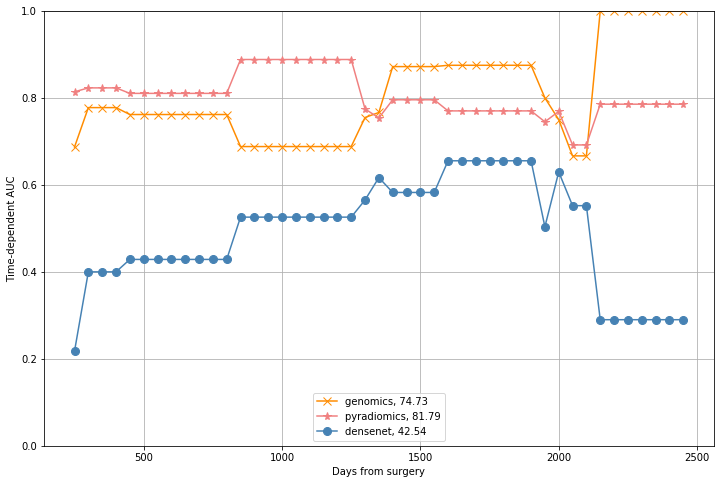

In [6]:
# estimate performance on training data, thus use `va_y` twice.
va_times = np.arange(250, 2500, 50)

plt.figure(figsize=(12, 8))

va_auc, va_mean_auc = cumulative_dynamic_auc(y_train, y_test, gen_outputs, va_times)
plt.plot(va_times, va_auc, color='darkorange', marker="x", label='genomics, ' +
         '{:.2f}'.format(va_mean_auc*100), markersize=8)
# plt.axhline(va_mean_auc, color='b', linestyle="--")
print('genomics', va_mean_auc)

va_auc, va_mean_auc = cumulative_dynamic_auc(y_train, y_test, pyrad_outputs, va_times)
plt.plot(va_times, va_auc, color='lightcoral', marker="*", label='pyradiomics, '+
         '{:.2f}'.format(va_mean_auc*100), markersize=8)
# plt.axhline(va_mean_auc, color='g', linestyle="--")
print('pyradiomics', va_mean_auc)

va_auc, va_mean_auc = cumulative_dynamic_auc(y_train, y_test, dense_outputs, va_times)
plt.plot(va_times, va_auc, color='steelblue', marker="o", label='densenet, '+
         '{:.2f}'.format(va_mean_auc*100), markersize=8)
# plt.axhline(va_mean_auc, color='g', linestyle="--")
print('densenet', va_mean_auc)

plt.xlabel("Days from surgery")
plt.ylabel("Time-dependent AUC")

plt.ylim(0, 1)
# plt.legend()
plt.legend(loc='lower center')  #, bbox_to_anchor=(1, 0.5))
plt.grid(True)

#### Multiple-modalities

genomics 0.7473368916040674
pyradiomics 0.8179288840268685
densenet 0.4254079899632076
feature2 0.8244989939953786
feature1 0.7627875250397393
feature3 0.8246972285786098


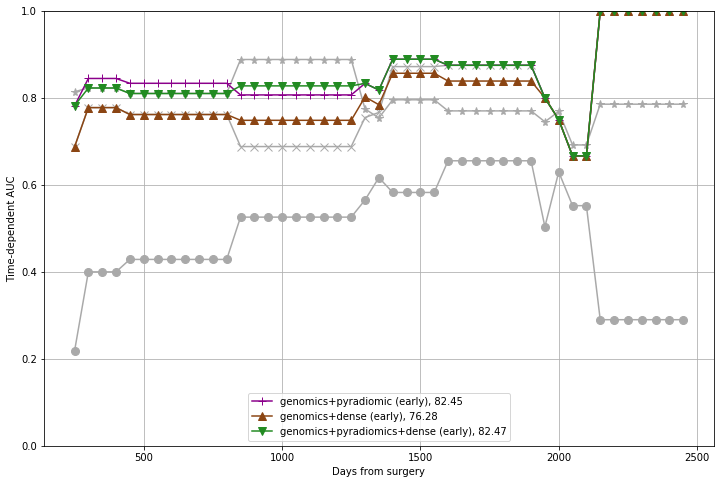

In [7]:
va_times = np.arange(250, 2500, 50)

plt.figure(figsize=(12, 8))

va_auc, va_mean_auc = cumulative_dynamic_auc(y_train, y_test, gen_outputs, va_times)
plt.plot(va_times, va_auc, color='darkgrey', marker="x",
         markersize=8)
print('genomics', va_mean_auc)

va_auc, va_mean_auc = cumulative_dynamic_auc(y_train, y_test, pyrad_outputs, va_times)
plt.plot(va_times, va_auc, color='darkgrey', marker="*", 
         markersize=8)
print('pyradiomics', va_mean_auc)

va_auc, va_mean_auc = cumulative_dynamic_auc(y_train, y_test, dense_outputs, va_times)
plt.plot(va_times, va_auc, color='darkgrey', marker="o",
         markersize=8)
print('densenet', va_mean_auc)

va_auc, va_mean_auc = cumulative_dynamic_auc(y_train, y_test, feat1_outputs, va_times)
plt.plot(va_times, va_auc, color='darkmagenta', marker="+", label='genomics+pyradiomic (early), '+
         '{:.2f}'.format(va_mean_auc*100), markersize=8)
print('feature2', va_mean_auc)

va_auc, va_mean_auc = cumulative_dynamic_auc(y_train, y_test, feat2_outputs, va_times)
plt.plot(va_times, va_auc, color='saddlebrown', marker="^", label='genomics+dense (early), '+
         '{:.2f}'.format(va_mean_auc*100), markersize=8)
print('feature1', va_mean_auc)

va_auc, va_mean_auc = cumulative_dynamic_auc(y_train, y_test, feat3_outputs, va_times)
plt.plot(va_times, va_auc , color='forestgreen', marker="v", label='genomics+pyradiomics+dense (early), '+
         '{:.2f}'.format(va_mean_auc*100), markersize=8)
print('feature3', va_mean_auc)

plt.xlabel("Days from surgery")
plt.ylabel("Time-dependent AUC")

plt.ylim(0, 1)
plt.legend(loc='lower center')
plt.grid(True)